K-Means

In [1]:
%load_ext google.cloud.bigquery
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm

In [2]:
sql = '''
SELECT *  FROM `eth-tokens.alldata.clean_avg`
'''

df = client.query(sql).to_dataframe()

In [3]:
#remove address (string) from analysis
data = df.iloc[:,1:]

In [4]:
#number of PCA features is full reconstruction, for now
num_features = data.shape[1]
num_clusters = 4

In [5]:
scale = StandardScaler()
pca =PCA(n_components=num_features)
cl = KMeans(num_clusters)
#build pipeline
pipe = Pipeline([('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(data)

cl.fit(results)



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [6]:
#get centroids
c = cl.cluster_centers_
#transform back to real numbers
medoids = scale.inverse_transform(pca.inverse_transform(c))
pd.DataFrame(medoids, columns = data.columns)

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_eth_sent,monthly_usd_sent,monthly_eth_recd,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns
0,25.251578,31.276976,3.156644e+02,29.908607,9.814805e+04,9371.436362,3.448275e+02,22.401415,9.934267e+04,7.276764e+03,...,21.583755,8.116438e+03,22.928266,8.360196e+03,2.884118e-01,9.780027e+00,8.851749e+05,1.063175e+06,1.136438e+06,1.273808e+06
1,424451.250000,169674.750000,3.620324e+06,600.098395,2.036619e+09,286965.089248,3.603474e+06,2722.819777,2.035262e+09,1.567950e+06,...,347422.644487,1.896901e+08,345814.263658,1.894076e+08,1.344869e-12,-1.798206e-11,1.257230e+04,1.992105e+04,3.365941e+03,9.047254e+03
2,14219.000000,20552.000000,1.957986e+07,1377.021048,1.120867e+09,78828.811477,1.959438e+07,953.405074,1.120732e+09,5.453152e+04,...,753071.626030,4.311026e+07,753630.041711,4.310507e+07,2.089828e-12,1.380940e-11,2.537501e+03,1.213661e+04,3.669439e+03,1.544081e+04
3,5.924604,8.617125,1.715125e+02,21.456315,2.768592e+04,4151.156675,1.723444e+02,20.760805,1.990805e+04,3.014809e+03,...,6.859491,1.542208e+03,7.083390,1.299918e+03,1.024129e-01,2.811601e+00,5.067974e+06,5.939139e+06,5.662692e+06,6.711128e+06


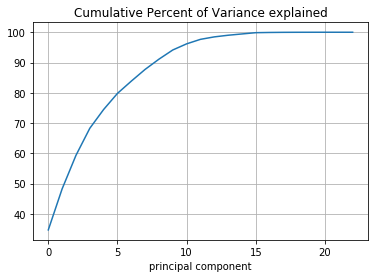

In [7]:
#percent of variance explained by each component

plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

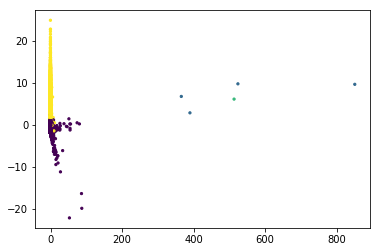

In [8]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_, s=5)

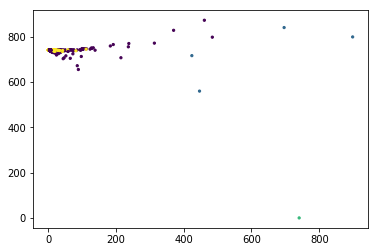

In [9]:
#plot in cluster distance space
r = cl.transform(results)
plt.scatter(r[:,3],r[:,2],c=cl.labels_, s=5)

In [10]:
#elbow method


In [11]:
#scoring metric?
from sklearn.metrics import calinski_harabaz_score as ch_score
clusters = [2, 3,4,5,6,7,8,9,10,12,15,20,25, 40]
scores = []
inertias = []
for c in clusters:
    cl_n = KMeans(c).fit(results)
    score = ch_score(results, cl_n.labels_)
    scores.append(score)
    inertias.append(cl_n.inertia_)


Text(0.5,1,'Calinski Harabaz Scores')

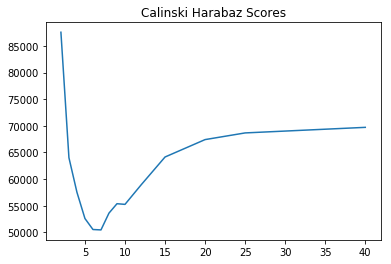

In [12]:
plt.plot(clusters, scores)
plt.title('Calinski Harabaz Scores')

Text(0,0.5,'within cluster sum of squares')

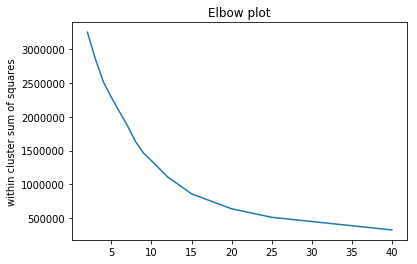

In [13]:
plt.plot(clusters,inertias)
plt.title('Elbow plot')
plt.ylabel('within cluster sum of squares')

In [14]:
#optmal number of clusters is around 12
cl = KMeans(12)
cl.fit(results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [15]:
#outlier removal



def remove_outliers(results, cl, threshold):
    '''
    returns subset of results, and associated labels as a tuple
    takes results and a fit KMeans cluster object'''
    
    new_labels = []
    new_results = []
    
    
    #code for deciding what clusters to keep
    for i, center in enumerate(cl.cluster_centers_):
        within_cluster_results = results[cl.labels_==i]
        centroid = cl.cluster_centers_[i]
        #calc std vectors
        stdev = np.std(within_cluster_results, axis=0)
       
        keep = np.linalg.norm((centroid - within_cluster_results), axis=1) < threshold*np.linalg.norm(stdev)
        new_results.append(within_cluster_results[keep])
        #add labels?
        new_labels.extend([i for j in range(len(within_cluster_results[keep]))])
    return np.vstack(new_results), np.array(new_labels)


In [16]:
thresholds = np.linspace(.3,3, 20)

test = [remove_outliers(results, cl,t) for t in thresholds]

scores= []
for (res, labels) in test:
    
    score = ch_score(res, labels)
    scores.append(score)

Text(0.5,1,'Calinski Harabaz Scores as std threshold changes')

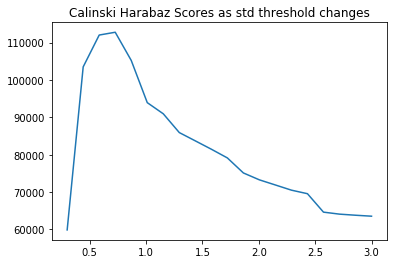

In [17]:
plt.plot(thresholds, scores)
plt.title('Calinski Harabaz Scores as std threshold changes')

In [18]:
#empirical best threshold .75 stdev
newresults, labels = remove_outliers(results, cl,.75)

(-15, 10)

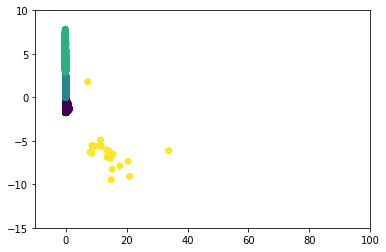

In [19]:
%matplotlib widget
fig = plt.subp
plt.scatter(newresults[:,0],newresults[:,1],c=labels)
plt.xlim(-10,100)
plt.ylim(-15,10)

(-15, 10)

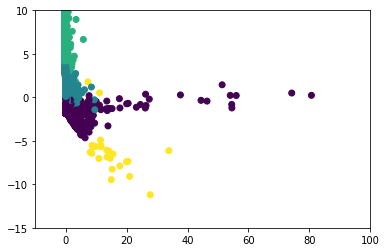

In [20]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_)
plt.xlim(-10,100)
plt.ylim(-15,10)

In [39]:
#recluster after changes
newcl = KMeans(12).fit(newresults)

In [41]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

FigureCanvasNbAgg()

In [ ]:

# plt.scatter(newresults[:,0],newresults[:,1],c=newcl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)